## STAT301 2024W2 Group 26 Project 
### Loading of Libraries & Dataset

In [8]:
suppressPackageStartupMessages({
library(haven)    # Loading of .dta, .csv etc. datasets
library(tidyverse)
library(dplyr)
library(datasets)
library(car)
# install.packages("vtable")    # maybe needed if not installed
# install.packages("corrplot")  # maybe needed if not installed
# install.packages("sandwich")  # maybe needed if not installed
# install.packages("lmtest")    # maybe needed if not installed
library(vtable)
library(corrplot)
library(sandwich)
library(lmtest)
library(repr)
library(tidymodels)
# install.packages("stargazer")      # maybe needed if not installed
library(stargazer)
library(modelr)
library(broom)
library(infer)
install.packages("ggmosaic")  # maybe needed if not installed
library(ggmosaic)
library(GGally)
library(coefplot)
})

Mise à jour de la liste HTML des packages dans '.Library'

Making 'packages.html' ...
 terminé



In [9]:
# Read the CSV file with specified column types 
market_data <- as_factor(read_delim("https://raw.githubusercontent.com/DrakenRaptor/STAT301_ProjectGrp26/refs/heads/main/marketing_campaign.csv", delim = "\t"))

# Check the structure of data types 
str(market_data)

head(market_data)
str(market_data$Dt_Customer)


Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [2,240 × 29] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ID                 : num [1:2240] 5524 2174 4141 6182 5324 ...
 $ Year_Birth         : num [1:2240] 1957 1954 1965 1984 1981 ...
 $ Education          : chr [1:2240] "Graduation" "Graduation" "Graduation" "Graduation" ...
 $ Marital_Status     : chr [1:2240] "Single" "Single" "Together" "Together" ...
 $ Income             : num [1:2240] 58138 46344 71613 26646 58293 ...
 $ Kidhome            : num [1:2240] 0 1 0 1 1 0 0 1 1 1 ...
 $ Teenhome           : num [1:2240] 0 1 0 0 0 1 1 0 0 1 ...
 $ Dt_Customer        : chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...
 $ Recency            : num [1:2240] 58 38 26 26 94 16 34 32 19 68 ...
 $ MntWines           : num [1:2240] 635 11 426 11 173 520 235 76 14 28 ...
 $ MntFruits          : num [1:2240] 88 1 49 4 43 42 65 10 0 0 ...
 $ MntMeatProducts    : num [1:2240] 546 6 127 20 118 98 164 56 24 6 ...
 $ MntFishProducts    : num [1:2240] 172 2 111 10 46 0 50 3

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,09-09-2013,16,520,⋯,6,0,0,0,0,0,0,3,11,0


 chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...


## Introduction & Data Description

The assigned dataset for the project is the Customer Personality Analysis found on In this project, the code below show the descriptive summary of the dataset.

### Data Description

This dataset consists of marketing campaign data for a company, with 2,240 observations and 28 variables. The data captures various attributes about customers, including demographic information, purchase history, and responses to marketing campaigns and purchase history.

| **Variable Name**       | **Type**     | **Description**                                               |
|-------------------------|--------------|---------------------------------------------------------------|
| `ID`                    | Character    | Unique identifier for each customer                           |
| `Year_Birth`            | Numeric      | Year of birth of the customer                                 |
| `Education`             | Character    | Education level of the customer                               |
| `Marital_Status`        | Character    | Marital status of the customer                                |
| `Income`                | Numeric      | Annual income of the customer                                 |
| `Kidhome`               | Numeric      | Number of children in the customer's household                |
| `Teenhome`              | Numeric      | Number of teenagers in the customer's household               |
| `Dt_Customer`           | Character    | Date of enrollment with the company                           |
| `Recency`               | Numeric      | Days since the last purchase                                  |
| `MntWines`              | Numeric      | Amount spent on wine                                          |
| `MntFruits`             | Numeric      | Amount spent on fruits                                        |
| `MntMeatProducts`       | Numeric      | Amount spent on meat products                                 |
| `MntFishProducts`       | Numeric      | Amount spent on fish products                                 |
| `MntSweetProducts`      | Numeric      | Amount spent on sweet products                                |
| `MntGoldProds`          | Numeric      | Amount spent on gold products                                 |
| `NumDealsPurchases`     | Numeric      | Number of purchases made with a discount                      |
| `NumWebPurchases`       | Numeric      | Number of purchases made through the web                      |
| `NumCatalogPurchases`   | Numeric      | Number of purchases made using a catalog                      |
| `NumStorePurchases`     | Numeric      | Number of purchases made directly in stores                   |
| `NumWebVisitsMonth`     | Numeric      | Number of visits to the company's website in the last month   |
| `AcceptedCmp3`          | Numeric      | 1 if the customer accepted the 3rd campaign, 0 otherwise      |
| `AcceptedCmp4`          | Numeric      | 1 if the customer accepted the 4th campaign, 0 otherwise      |
| `AcceptedCmp5`          | Numeric      | 1 if the customer accepted the 5th campaign, 0 otherwise      |
| `AcceptedCmp1`          | Numeric      | 1 if the customer accepted the 1st campaign, 0 otherwise      |
| `AcceptedCmp2`          | Numeric      | 1 if the customer accepted the 2nd campaign, 0 otherwise      |
| `Response`              | Numeric      | 1 if the customer accepted the last campaign, 0 otherwise     |
| `Complain`              | Numeric      | 1 if the customer has complained in the last 2 years, 0 otherwise |
| `Country`               | Character    | Country of the customer                                       |

**Data Source**: The dataset was collected as part of a marketing campaign analysis by Dr. Omar Romero-Hernandez. https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data


## Research Question (Question of Interest)

Customer Personality Analysis is essential to help a firm to modify its product to meet the needs of customers from different segments. In this project, I wish to predict of the amount of gold products `MntGoldProds` spent among customers against the different covariates or predictors such as customer's `Income`, level of education, `NumStorePurchases`, `NumWebPurchases`, `NumCatalogPurchases`, `NumWebVisitsMonth`.


**<br> Legend:**
- `MntGoldProds` is the response variable, where the amount of gold is a numeric variable
- `Income` is one of the covariates which is dependent on how much does the customer earn in a year
- `NumWebPurchases` is one of the covariates or predictor which represents the number of web purchases made through the company's website.
- `NumStorePurchases` is one of the covariates or predictor which represents the number of purchases made in store.
- `Marital_Status` is a categorical variable which can be represented by numerical
- `Education` is one of the 

The code belows shows the unique values present in the `Education` and `Marital_Status` column of the `market_data` data frame. 


In [10]:
unique(market_data$Education)  
unique(market_data$Marital_Status)     # Possible covariates to be used as factor variables for research model, to classify YOLO as single?
market_data_web <- market_data |>
    select(MntGoldProds)

head(market_data_web)
tail(market_data_web)

mean_mnt_gold_prods <- mean(market_data$MntGoldProds, na.rm = TRUE)
var_mnt_gold_prods <- var(market_data$MntGoldProds, na.rm = TRUE)

mean_mnt_gold_prods
var_mnt_gold_prods

# Extract the unique values and their counts
education_counts <- table(market_data$Education)
education_counts


# Extract Unique values of Marital Status
marital_counts <- table(market_data$Marital_Status)
marital_counts


[1] "Graduation" "PhD"        "Master"     "Basic"      "2n Cycle"

[1] "Single"   "Together" "Married"  "Divorced" "Widow"    "Alone"    "Absurd"  
[8] "YOLO"

MntGoldProds
<dbl>
88
6
42
5
15
14


MntGoldProds
<dbl>
9
247
8
24
61
21


[1] 44.02188

[1] 2721.442


  2n Cycle      Basic Graduation     Master        PhD 
       203         54       1127        370        486 


  Absurd    Alone Divorced  Married   Single Together    Widow     YOLO 
       2        3      232      864      480      580       77        2 

### EDA and Visualisation

From the code above, there's seem to be the a huge amount of respondents who possess `2n Cycle` education level. This means that there's a need to include this in the analysis. Since `2n Cycle` is the same as Master's Degree as found in https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/discussion/466400. The code below shows the wrangling tp include them as `Master`. 
A correlation plot maybe suitable to check for the relationship between the continuous random variable such as `Income`, `NumCatalogPurchases`, `NumWebVisitsMonth`, `NumStorePurchases`, `NumWebPurchases`.

A correlation plot maybe suitable to check for the relationship between the continuous random variable such as `Income`, `NumCatalogPurchases`, `NumWebVisitsMonth`, `NumStorePurchases`, `NumWebPurchases`.

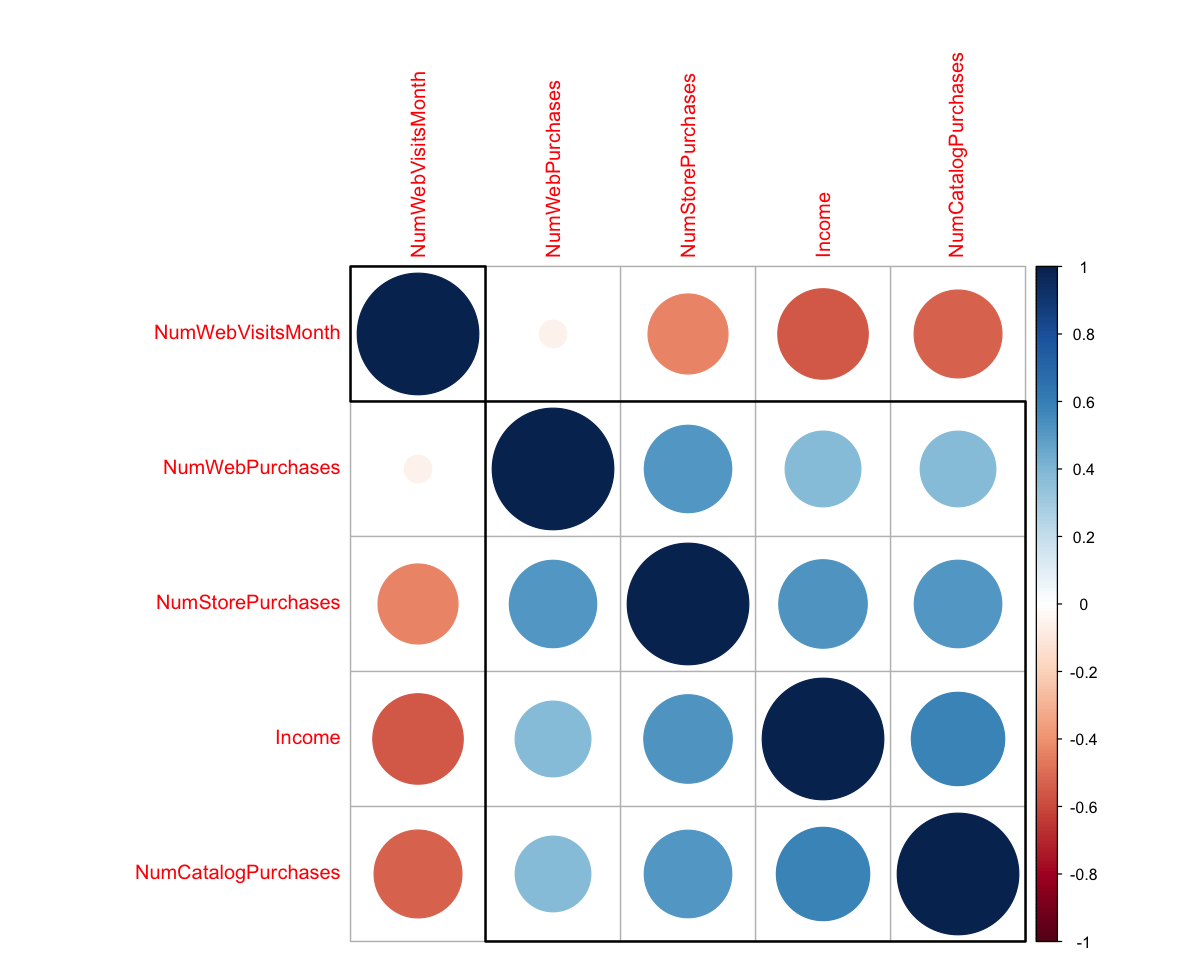

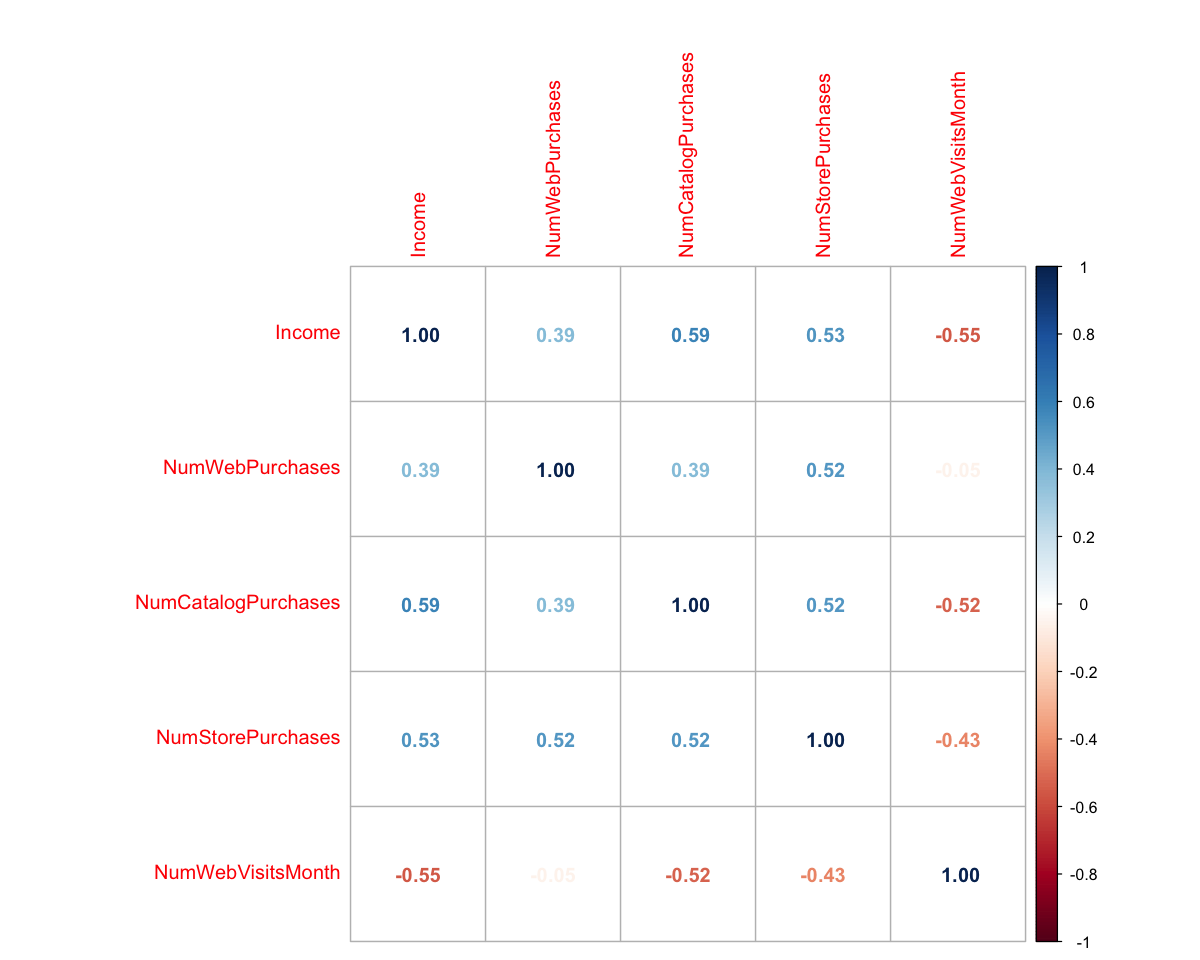

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)
# Using correlation plot to check the relationship between the variables
corr_plt_dat <- market_data[, c("Income", "NumWebPurchases", "NumCatalogPurchases",
 "NumStorePurchases", "NumWebVisitsMonth")] |>
    as.data.frame()

# Ensure there are no missing values
corr_plt_dat <- na.omit(corr_plt_dat)

cor_matrix <- cor(corr_plt_dat)

corrplot(cor_matrix, order = "hclust", addrect = 2)
corrplot(cor_matrix, method = "number", addrect = 2)

Warning message:
“The `scale_name` argument of `continuous_scale()` is deprecated as of ggplot2
3.5.0.”
Warning message:
“The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead.”
Warning message:
“`unite_()` was deprecated in tidyr 1.2.0.
ℹ Please use `unite()` instead.
ℹ The deprecated feature was likely used in the ggmosaic package.
  Please report the issue at <https://github.com/haleyjeppson/ggmosaic>.”


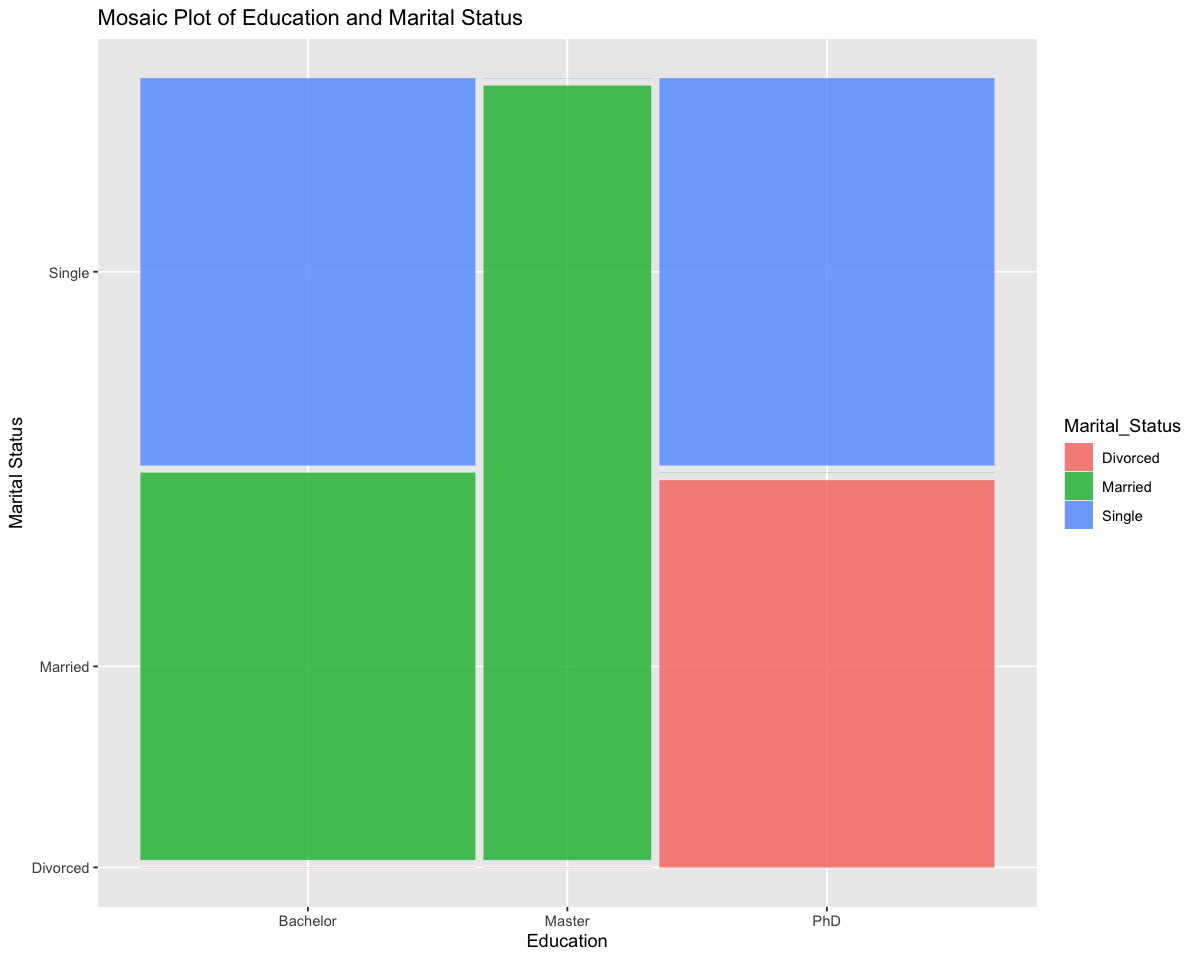

In [12]:
market_data <- data.frame(
  Education = factor(c("PhD", "Master", "Bachelor", "PhD", "Bachelor")),
  Marital_Status = factor(c("Single", "Married", "Single", "Divorced", "Married"))
)

# Create a mosaic plot
ggplot(data = market_data) +
  geom_mosaic(aes(weight = 1, x = product(Education), fill = Marital_Status)) +
  labs(title = "Mosaic Plot of Education and Marital Status", x = "Education", y = "Marital Status")